# Tutorial 3: Finding the optimal CE model

In this tutorial, you will learn how to build a cluster expansion model for a complex surface system.

## The optimal model

Once a training data set and a pool of clusters are available, the next question is how to find the optimal cluster expansion model to make actual predictions. This task requires finding the set of clusters that best describes the relevant interactions present in the system. Various optimality criteria can be used. Here we will focus on obtaining models which are optimal in the sense of providing the best possible predictions for *new* data, i.e., data not yet included in the training set. For this purpose, the quality of the predictions can be estimated by the cross validation score (CVS), which you will learn to calculate and interpret in this section.

Here, we will use the surface system with oxygen adsorption and Na substitution, which was used in **Tutorial 1**, to build a cluster expansion model. We start by generating the needed elements for the task, namely a training data set and a pool of clusters.

In [22]:
%matplotlib inline 
from ase.build import fcc111, add_adsorbate # ASE's utilities to build the surface
from clusterx.parent_lattice import ParentLattice 
from clusterx.structures_set import StructuresSet
from clusterx.visualization import juview
from clusterx.super_cell import SuperCell
from random import randint
import numpy as np

# Build a 3-layer Al slab with vacancy in on-top configuration
pri2 = fcc111('Pd', size=(1, 1, 3))  # 3-atomic-layer Al slab
pri2.center(vacuum=10.0, axis=2)  # add vacuum along z-axis
platt2 = ParentLattice(pri2, site_symbols=[['Pd', 'Au'], ['Pd', 'Au'], ['Pd', 'Au']])
scell2 = SuperCell(platt2, [4, 4])
sset2 = StructuresSet(platt2)
nstruc = 60

for i in range(nstruc):
    atoms_object = scell2.gen_random(24)
    sset2.add_structure(atoms_object) 

print("\nRandom structures (first 3):")
 # Write JSON db file for visualization with ASE's GUI.
juview(sset2,n=2) # Plot the first 3 created random structrues


Random structures (first 3):


![Random structures](fig3-1.png)

We have just created 60 random structures at several concentrations. Now, we need to calculate the total energies. The structural information with the associated energies will form our training set. This will be used to train a CE model for predicting total energies. In order to save time in this tutorial, we will not calculate the energies with an *ab initio* code like `exciting`, but instead we will use the Effective Mean Theory calculator from ASE. This calculator provides energies which are not realistic, but which well serve the purpose to test and aquire basic training on the CE methodology. 

In [23]:
from clusterx.calculators.emt import EMT2 # Load the EMT calculator from ASE
from clusterx.visualization import plot_property_vs_concentration

sset2.set_calculator(EMT2())
sset2.calculate_property("total_energy_emt") # Calculate energies with Effective Medium Theory calculator of ASE
vars(sset2)['_props']["total_energy_emt"]=np.array([-192.08582071, -191.87351734, -191.60018779, -191.39685004, -192.24290787, -191.78014638, -191.70745162, -192.97458495, -192.86267872, -191.37195796, -192.3143272, -192.14009737, -192.82585879, -192.05420399, -192.69999995, -192.47746079, -192.39000526, -192.26897121, -192.3791746, -192.43099895, -191.77825841, -191.61704212, -191.47478811, -192.03389507, -192.07830785, -192.69342232, -192.2408292, -192.54062519, -191.91839647, -192.51096022, -192.69325283, -192.17466602, -192.59825086, -191.72542479, -191.58574526, -192.14693661, -191.82264476, -192.03231015, -192.22406236, -192.13476996, -192.37122734, -192.14574102, -192.44934157, -192.39786595, -192.43562855, -192.91115595, -191.68967308, -191.88094222, -192.55731336, -191.98716311, -192.47554187, -192.06452466, -192.08788961, -192.66728046, -192.83996271, -192.76515741, -192.77311024, -191.68482559, -191.25609343, -191.73848187])
vars(sset2)['_props']["total_energy_emt"]

array([-192.08582071, -191.87351734, -191.60018779, -191.39685004,
       -192.24290787, -191.78014638, -191.70745162, -192.97458495,
       -192.86267872, -191.37195796, -192.3143272 , -192.14009737,
       -192.82585879, -192.05420399, -192.69999995, -192.47746079,
       -192.39000526, -192.26897121, -192.3791746 , -192.43099895,
       -191.77825841, -191.61704212, -191.47478811, -192.03389507,
       -192.07830785, -192.69342232, -192.2408292 , -192.54062519,
       -191.91839647, -192.51096022, -192.69325283, -192.17466602,
       -192.59825086, -191.72542479, -191.58574526, -192.14693661,
       -191.82264476, -192.03231015, -192.22406236, -192.13476996,
       -192.37122734, -192.14574102, -192.44934157, -192.39786595,
       -192.43562855, -192.91115595, -191.68967308, -191.88094222,
       -192.55731336, -191.98716311, -192.47554187, -192.06452466,
       -192.08788961, -192.66728046, -192.83996271, -192.76515741,
       -192.77311024, -191.68482559, -191.25609343, -191.73848

In the next cell, we will create a small structures set containing just two structures: one pristine, non-substituted and free of adsorbants, and the other a fully substituted one (Al->Na), still without O adsorbants. The energies $E_0$ and $E_1$ of these structures will serve as references for generating figures depicting the total energy versus concentration: $e=E - E0*(1-x)+E1*x$, with $E$ the EMT energy of the structure and $x$ the Na concentration.

In [24]:
refs = StructuresSet(platt2)
refs.add_structure(scell.gen_random({0:[0],1:[0]})) # Pristine
refs.add_structure(scell.gen_random({0:[0],1:[16]})) # Full Na substitution
refs.set_calculator(EMT2())
refs.calculate_property("total_energy_emt_refs")
ref_en = refs.get_property_values("total_energy_emt_refs")

plot_property_vs_concentration(sset2,property_name="total_energy_emt",refs=ref_en,scale=0.7)

NameError: name 'scell' is not defined

The information in this figure comprises the training set. The $x$ axis indicates the concentration of Na on the top-most layer. For a given Na concentration, several points in the plot correspond to different structures of the training set having different arrangements of Na and O atoms, and/or different concentration of O atoms. The units of energy are arbitrary. 

The next step is to create a pool of cluters:

In [25]:
r=3.5
from clusterx.clusters.clusters_pool import ClustersPool
cpool = ClustersPool(platt2, npoints=[0,1,2,3,4], radii=[0,0,r,r,r])
print(len(cpool)," clusters were generated.")

13  clusters were generated.


In [27]:

juview(cpool.get_cpool_atoms(),n=13)

![Clusters pool](fig3-2.png)

Above, only a few of the training structures and generated clusters are displayed. If you would like to visualize them all, use the ASE's gui interface as explained in **Tutorial 2**. 

Now that we have the basic elements (i.e. the training set `sset` and the pool of clusters `cpool`), we can proceed to build different CE models and to analyze the corresponding predictions. This is achieved by using the [ModelBuilder](https://sol.physik.hu-berlin.de/cell/modules/model_builder.html) class of **CELL**. The input parameters of this class define two essential tasks: *i)* The selection of relevant clusters, and *ii)* the fitting procedure. For the first task the relevant parameters are `selector_type` and `selector_opts`. In this tutorial we will use two different selectors, one of them (`linreg`) uses a cross validation strategy on cluster subsets of increasing size, the other (`lasso`) uses compressed sensing techniques to obtain sparse models. For the second task, the relevant parameters are `estimator_type` and `estimator_opts`. In this tutorial, we will use in all cases the `LinearRegression` estimator of [sci-kit learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression) for fitting. All the sci-kit learn estimators plus native estimators from CELL are available in CELL through the [EstimatorFactory](https://sol.physik.hu-berlin.de/cell/modules/estimator_factory.html) class. 

The [ModelBuilder](https://sol.physik.hu-berlin.de/cell/modules/model_builder.html) encapsulates several complex tasks embodied in classes like [ClustersSelector](https://sol.physik.hu-berlin.de/cell/modules/clusters_selector.html), [EstimatorFactory](https://sol.physik.hu-berlin.de/cell/modules/estimator_factory.html), [CorrelationsCalculator](https://sol.physik.hu-berlin.de/cell/modules/correlations.html), etc. which can be used separately in more advanced applications of CELL.

Now, run the following listing and analize the reported results:

In [14]:
from clusterx.model import ModelBuilder

mb = ModelBuilder(selector_type="linreg",selector_opts={'clusters_sets':'size'},estimator_type="skl_LinearRegression",estimator_opts={"fit_intercept":False})
cemodel1 = mb.build(sset2, cpool, 'total_energy_emt') #Build CE model using the training data set
cpool_opt1 = mb.get_opt_cpool()

cemodel1.report_errors(sset2)
cpool_opt1.display_info(ecis=cemodel1.get_ecis())
print(sset2.get_structure(1))
print(sset2.get_structure(1).get_sigmas())

C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was d

C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was d


+-----------------------------------------------------------+
|                Report of Fit and CV scores                |
+-----------------------------------------------------------+
|                   |        Fit        |        CV         |
+-----------------------------------------------------------+
|       RMSE        |      0.42676      |      0.43399      |
|        MAE        |      0.35521      |      0.36123      |
|       MaxAE       |      0.92859      |      0.94432      |
+-----------------------------------------------------------+


+-------------------------------------------------------------------------------+
|                             Clusters Pool Info                                |
+-------------------------------------------------------------------------------+
|       Index       |   Nr. of points   |      Radius       |        ECI        |
+-------------------------------------------------------------------------------+
|         0         |        

The first Table contains a detailed report of prediction errors for the optimal model found by [ModelBuilder](https://sol.physik.hu-berlin.de/cell/modules/model_builder.html), both from the fit and by cross-validation. Different metrics are used: RMSE indicates the root-mean-square-error, MAE the mean absolute error, and MaxAE the maximum absolute error. Observe that in general the errors from CV are slightly larger than for the fit. Why is this so? 

The second table shows information on the optimal pool of clusters and the corresponding effective cluster interactions (ECI). Note that for clusters with increasing number of points and radius, the interactions get smaller. Can you give a reason for this behavior?

In the next listing we will generate three figures that are very informative: 

The first of them shows how the optimality criterium based on CV works: For increasing numbers of clusters, the error of the fit (label "training-RMSE") decreases monotonously. In contrast, the CV score (label "cv-RMSE") has a minimum, which represents the crossover from models showing *underfitting*, i.e. poor fitting due to having few parameters, and models presenting *overfitting*, i.e. models with too many parameters (i.e. clusters), which are prone to fit noise. The red circle in this figure indicates the optimal model found.

The second plot shows, for every structure in the training set, the calculated energy versus the predicted energy. Since all the points lie in the solid stright line, this means that the predictions are good. 

The third plot shows the calculated, predicted, and cross validated predictions as a function of Na concentration. As you can see, the predictions are quite accurate except for a few data points. Also, the predicted values are consistently better than the cross-validated predictions, as expected.

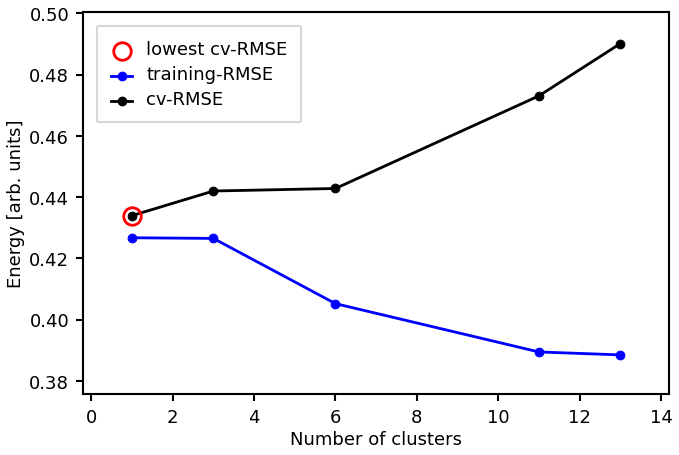

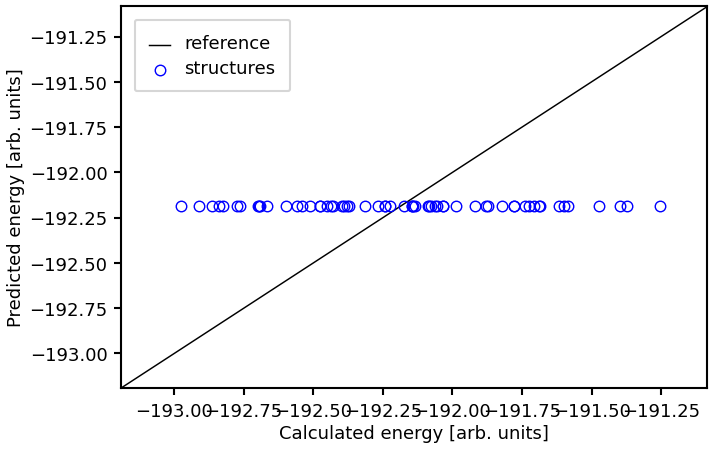

NameError: name 'ref_en' is not defined

In [15]:
from clusterx.visualization import plot_optimization_vs_number_of_clusters
from clusterx.visualization import plot_predictions_vs_target
plot_optimization_vs_number_of_clusters(mb.get_selector(),scale=0.7)
plot_predictions_vs_target(sset2,cemodel1,"total_energy_emt",scale=0.7)
plot_property_vs_concentration(sset2,property_name="total_energy_emt",cemodel=cemodel1,refs=ref_en,scale=0.7)

Next, we will experiment with a different optimization procedure by changing the `clusters_sets` parameter from `"size"` to `"size+combinations"` (and adding two additional parameters, `nclmax` and `set0`). By setting `clusters_sets` to `"size+combinations"`, all the clusters pools for the CV procedure will be formed by a fixed pool with clusters up to 1 point and radius 0 (indicated by `set0 = [1,0]`) plus all possible cluster subsets (i.e. all possible combinations) of size `nclmax` (1 in the example below) from the reamining in the clusters pool. Below a minimal example of this is given:

In [16]:
mb = ModelBuilder(selector_type="linreg",selector_opts={'clusters_sets':'size+combinations','nclmax':1,'set0':[1,0]},estimator_type="skl_LinearRegression",estimator_opts={"fit_intercept":False})
cemodel2 = mb.build(sset2, cpool, "total_energy_emt") #Build CE model using the training data set
cpool_opt2 = mb.get_opt_cpool()

cemodel2.report_errors(sset2)
cpool_opt2.display_info(ecis=cemodel2.get_ecis())


C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was d

C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was d

C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was d

C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was d


+-----------------------------------------------------------+
|                Report of Fit and CV scores                |
+-----------------------------------------------------------+
|                   |        Fit        |        CV         |
+-----------------------------------------------------------+
|       RMSE        |      0.41097      |      0.43390      |
|        MAE        |      0.33596      |      0.35396      |
|       MaxAE       |      1.11487      |      1.20731      |
+-----------------------------------------------------------+


+-------------------------------------------------------------------------------+
|                             Clusters Pool Info                                |
+-------------------------------------------------------------------------------+
|       Index       |   Nr. of points   |      Radius       |        ECI        |
+-------------------------------------------------------------------------------+
|         0         |        

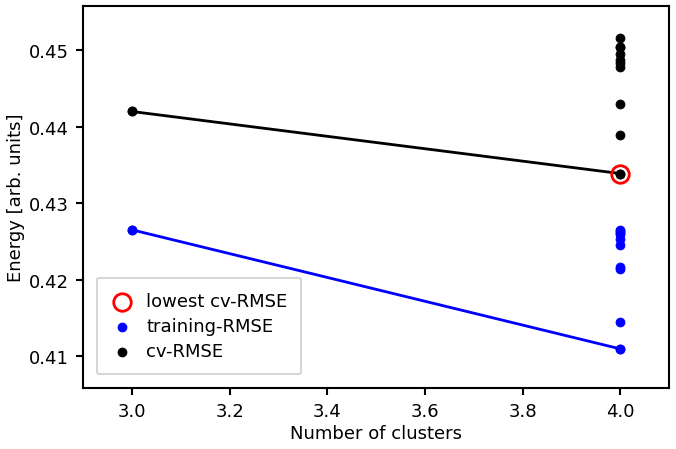

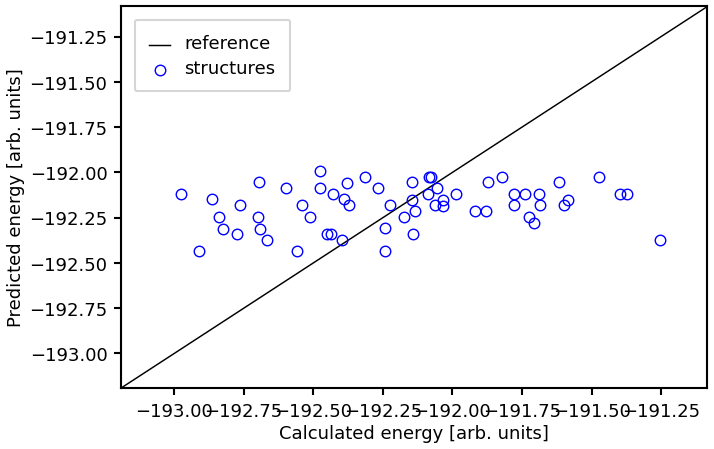

NameError: name 'ref_en' is not defined

In [17]:
plot_optimization_vs_number_of_clusters(mb.get_selector(),scale=0.7)
plot_predictions_vs_target(sset2,cemodel2,"total_energy_emt",scale=0.7)
plot_property_vs_concentration(sset2, property_name="total_energy_emt",cemodel=cemodel2,refs=ref_en,scale=0.7)

As you can see, the selection of small values for the parameters `nclmax` and `set0` leads to poor quality of the predictions above. 

Below, larger values are set for these parameters. The combinatorial search takes more time now, but the quality of the model improves considerably:

In [18]:
mb = ModelBuilder(selector_type="linreg",selector_opts={'clusters_sets':'size+combinations','nclmax':3,'set0':[2,3.5]},estimator_type="skl_LinearRegression",estimator_opts={"fit_intercept":False})
cemodel3 = mb.build(sset2, cpool, "total_energy_emt") #Build CE model using the training data set
cpool_opt3 = mb.get_opt_cpool()

cemodel3.report_errors(sset2)
cpool_opt3.display_info(ecis=cemodel3.get_ecis())

C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was d

C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was d

C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was d

C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was d

C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was d

C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was d

C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was d

C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was d

C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was d

C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was d

C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was d

C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was d

C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was d

C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was d

C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was d

C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was d

C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was d

C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was d

C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was d

C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was d

C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was d

C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was d


+-----------------------------------------------------------+
|                Report of Fit and CV scores                |
+-----------------------------------------------------------+
|                   |        Fit        |        CV         |
+-----------------------------------------------------------+
|       RMSE        |      0.39711      |      0.44070      |
|        MAE        |      0.32054      |      0.35628      |
|       MaxAE       |      1.13596      |      1.23781      |
+-----------------------------------------------------------+


+-------------------------------------------------------------------------------+
|                             Clusters Pool Info                                |
+-------------------------------------------------------------------------------+
|       Index       |   Nr. of points   |      Radius       |        ECI        |
+-------------------------------------------------------------------------------+
|         0         |        

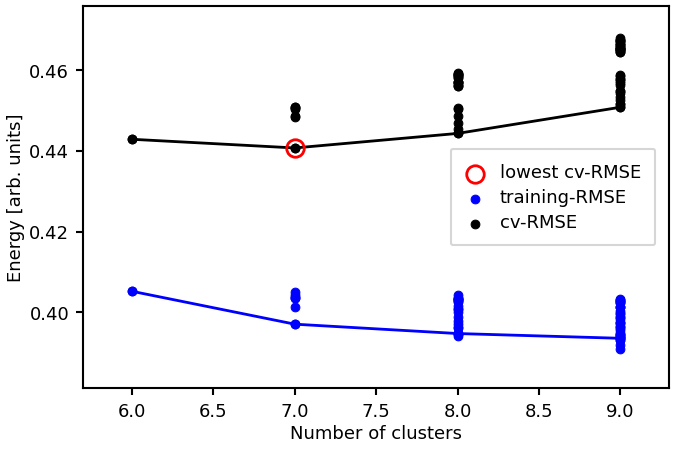

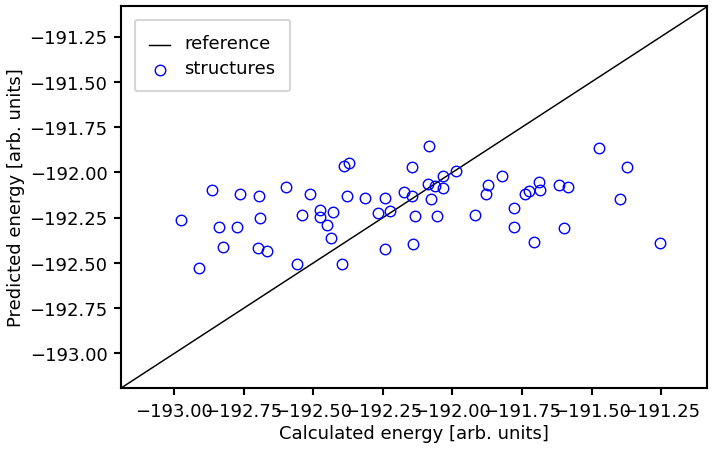

NameError: name 'ref_en' is not defined

In [19]:
plot_optimization_vs_number_of_clusters(mb.get_selector(),scale=0.7)
plot_predictions_vs_target(sset2,cemodel3,"total_energy_emt",scale=0.7)
plot_property_vs_concentration(sset2,property_name="total_energy_emt",cemodel=cemodel3,refs=ref_en,scale=0.7)

In the next example, we will perform cluster selection with LASSO (Least Absolute Shrinkage and Selection Operator), using cross-validation for selecting the sparsity hyper-parameter. To this end, we change the first argument from `"linreg"` to `"lasso"`, and we indicate the sparsity range (`sparsity_max` and `sparsity_min`) for the hyper-parameter determination through cross-validation.

In [20]:
mb = ModelBuilder(selector_type="lasso",selector_opts={'sparsity_max': 0.1,'sparsity_min': 0.001},estimator_type="skl_LinearRegression",estimator_opts={"fit_intercept":False})
cemodel4 = mb.build(sset2, cpool, "total_energy_emt") #Build CE model using the training data set
cpool_opt4 = mb.get_opt_cpool()

cemodel4.report_errors(sset2)
cpool_opt4.display_info(ecis=cemodel4.get_ecis())


C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was d

C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was d

C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was d

C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was d

C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was d

C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was d


+-----------------------------------------------------------+
|                Report of Fit and CV scores                |
+-----------------------------------------------------------+
|                   |        Fit        |        CV         |
+-----------------------------------------------------------+
|       RMSE        |      0.42676      |      0.43399      |
|        MAE        |      0.35521      |      0.36123      |
|       MaxAE       |      0.92859      |      0.94432      |
+-----------------------------------------------------------+


+-------------------------------------------------------------------------------+
|                             Clusters Pool Info                                |
+-------------------------------------------------------------------------------+
|       Index       |   Nr. of points   |      Radius       |        ECI        |
+-------------------------------------------------------------------------------+
|         0         |        

C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
C:\Users\Max\PycharmProjects\Project1\venv\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was d

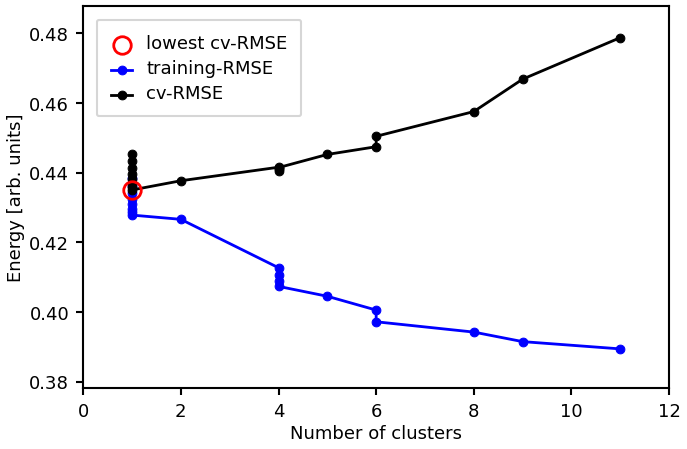

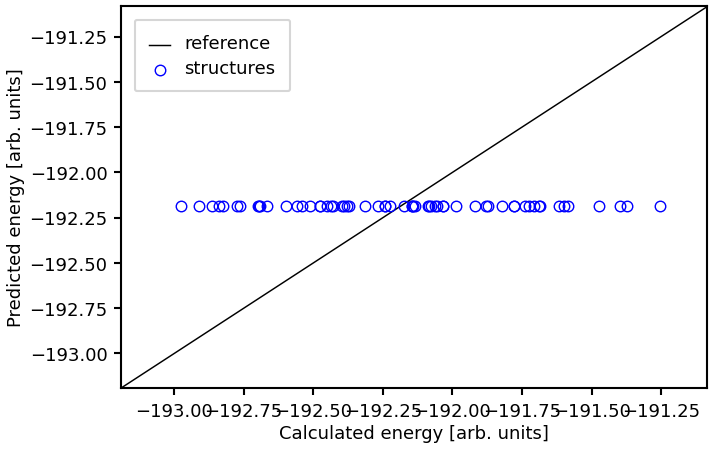

NameError: name 'ref_en' is not defined

In [21]:
plot_optimization_vs_number_of_clusters(mb.get_selector(),scale=0.7)
plot_predictions_vs_target(sset2,cemodel4,"total_energy_emt",scale=0.7)
plot_property_vs_concentration(sset2,property_name="total_energy_emt",cemodel=cemodel4,refs=ref_en,scale=0.7)

In order to see if the selected sparsity range contains the optimal sparsity, it is very informative to plot the cross-validation procedure for the hyperparameter. This is done with the `plot_optimization_vs_sparsity` function of the [visualization](https://sol.physik.hu-berlin.de/cell/modules/visualization.html) module:

In [ ]:
from clusterx.visualization import plot_optimization_vs_sparsity
plot_optimization_vs_sparsity(mb.get_selector())  

## Excercise 5

Perform a model optimization for the square Si-Ge binary lattice of **Tutorial 2**. Use the different strategies explained in this tutorial, i.e.: `"linreg"` with `"size"` and `"size+combinations"` and `"lasso"`. Interpret the results.